In [1]:
#__Author__ = "Chen Zhang"
from DataPreprocessing import DataInit, LGBM_FeatureSelection as FS
#package I wrote, containg initialization of datas, feature selections

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Initializing Datas

In [3]:
train_trans = pd.read_csv(r'..\data\train_transaction_new.csv', index_col='TransactionID')
train_id = pd.read_csv(r'..\data\train_identity_new.csv', index_col='TransactionID')

test_trans = pd.read_csv(r'..\data\test_transaction_new_nolabel.csv', index_col='TransactionID')
test_id = pd.read_csv(r'..\data\test_identity_new.csv', index_col='TransactionID')

In [4]:
train_raw = train_trans.merge(test_id, how='left', left_index=True, right_index=True)
target_raw = test_trans.merge(test_id, how='left', left_index=True, right_index=True)
target_raw.insert(loc=0,column='isFraud',value=0)

In [5]:
transaction_cat_data_list = [3,4,5,6,7,8,9,10,11,14,15] + list(range(45,54))
data_cat_data_list = transaction_cat_data_list + list(range(392+12,392+41))

In [6]:
data = DataInit(train_raw, target_raw, data_cat_data_list, dropping_list=[1])

In [7]:
data.train_x

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3379840,-0.437961,-2.273059,-1.595233,0.308872,2.414377,0.643344,-2.256241,-1.679215,-1.546406,-2.835276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3415851,-0.365802,-0.863972,0.037220,1.408793,-0.202174,0.643344,0.661603,-1.679215,0.586847,0.356219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3269438,0.386127,0.545114,-1.478316,0.019750,-0.202174,0.643344,0.661603,0.578667,-1.325725,0.356219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3554694,-0.486700,-2.273059,-0.421679,-0.967037,2.414377,0.643344,-1.385243,0.578667,-1.546406,-2.835276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2994660,-0.468551,0.545114,0.170213,0.013464,-0.202174,-0.973861,-1.864292,0.578667,-0.712721,0.356219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998035,0.151149,0.545114,0.674417,1.220235,-0.202174,0.643344,0.661603,-1.679215,-1.350245,0.356219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3158790,-0.455520,0.545114,-0.912731,1.408793,-0.202174,0.643344,0.661603,-1.679215,-0.516560,0.356219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3278176,-0.327351,0.545114,-0.738329,1.188809,-0.202174,0.643344,0.661603,0.578667,1.494093,0.356219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engeering

### Using Random Forest to get features importance

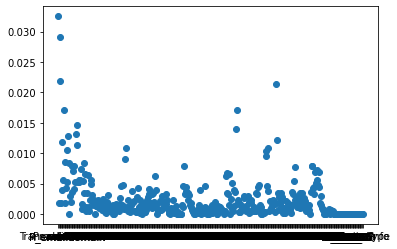

In [8]:
RFR = RandomForestRegressor(max_samples=1000, max_features=100, max_depth=20)#, max_depth=10)
RFR.fit(data.train_ x, data.train_y)
features = data.train_x.columns
importances = RFR.feature_importances_
plt.scatter(features, importances)
plt.show()

In [9]:
important_feature_count = 0
for i in list(importances):
    if i > 1e-4:
        important_feature_count+=1
important_feature_count

359

# Greedy Feature Selection on Low Importance Features by LGBM

In [10]:
LIF_list = []
threshold = 1e-3
for i in range(len(importances)):
    if importances[i] < threshold:
        LIF_list.append(features[i])

In [11]:
fs = FS(data,LIF_list)
fs.feature_regressor()
drop_features = []
for i in range(len(fs.result)):
    if fs.result[i] == 1:
        drop_features.append(LIF_list[i])
drop_features = ['C3', 'M1', 'M2', 'V1', 'V9', 'V11', 'V14', 'V15', 'V16', 'V22', 'V27', 'V28', 'V29', 'V31', 'V32', 'V41', 'V42', 'V46', 'V48', 'V49', 'V50', 'V51', 'V55', 'V58', 'V65', 'V68', 'V69', 'V70', 'V79', 'V84', 'V89', 'V90', 'V91', 'V93', 'V104', 'V105', 'V106', 'V107', 'V110', 'V111', 'V112', 'V114', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V138', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V152', 'V154', 'V155', 'V159', 'V160', 'V162', 'V166', 'V167', 'V169', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V179', 'V180', 'V181', 'V182', 'V185', 'V193', 'V196', 'V197', 'V202', 'V205', 'V206', 'V210', 'V215', 'V216', 'V217', 'V225', 'V227', 'V228', 'V235', 'V236', 'V237', 'V238', 'V240', 'V241', 'V248', 'V252', 'V253', 'V265', 'V267', 'V268', 'V269', 'V276', 'V286', 'V287', 'V303', 'V304', 'V305', 'V323', 'V325', 'V327', 'V328', 'V330', 'V331', 'V335', 'V336', 'V337', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [12]:
len(LIF_list), len(drop_features)
data.feature_dropping(drop_features)

In [13]:
data.train_x

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V320,V321,V322,V324,V326,V329,V332,V333,V334,V338
TransactionID,,,,,,,,,,,,,,,,,,,,,
3379840,-0.437961,-2.273059,-1.595233,0.308872,2.414377,0.643344,-2.256241,-1.679215,-1.546406,-2.835276,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291
3415851,-0.365802,-0.863972,0.037220,1.408793,-0.202174,0.643344,0.661603,-1.679215,0.586847,0.356219,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291
3269438,0.386127,0.545114,-1.478316,0.019750,-0.202174,0.643344,0.661603,0.578667,-1.325725,0.356219,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291
3554694,-0.486700,-2.273059,-0.421679,-0.967037,2.414377,0.643344,-1.385243,0.578667,-1.546406,-2.835276,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291
2994660,-0.468551,0.545114,0.170213,0.013464,-0.202174,-0.973861,-1.864292,0.578667,-0.712721,0.356219,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998035,0.151149,0.545114,0.674417,1.220235,-0.202174,0.643344,0.661603,-1.679215,-1.350245,0.356219,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291
3158790,-0.455520,0.545114,-0.912731,1.408793,-0.202174,0.643344,0.661603,-1.679215,-0.516560,0.356219,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291
3278176,-0.327351,0.545114,-0.738329,1.188809,-0.202174,0.643344,0.661603,0.578667,1.494093,0.356219,...,-0.104191,-0.099449,-0.040188,-0.045024,-0.076926,-0.053668,-0.044267,-0.045699,-0.02549,-0.056291


# Bayesian Neural Network

以下中为各个结构的神经网络的尝试，测试中发现差别不大，故采用第一个

In [15]:
@variational_estimator
class BayesianNN(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.blinear = BayesianLinear(input_dim, input_dim)
        self.blinear1 = BayesianLinear(input_dim, 400)
        self.linear1 = nn.Linear(400, 250)
        self.linear2 = nn.Linear(250, 50)
        self.linear3 = nn.Linear(50, 15)
        self.linear = BayesianLinear(15, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.blinear(x))
        x = torch.relu(self.blinear1(x))
        x = F.dropout(x, p=0.20)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        #x = F.relu(self.linear4(x))
        #x = F.relu(self.linear5(x))
        #x = F.relu(self.linear6(x))
        x = torch.sigmoid(self.linear(x))
        return x
    
    def store(self):
        torch.save(self.state_dict(), 'best_model.txt')


In [16]:
@variational_estimator
class BayesianNN1(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.blinear = BayesianLinear(input_dim, input_dim)
        self.linear1 = nn.Linear(input_dim, 400)
        self.linear2 = nn.Linear(400, 50)
        self.linear3 = nn.Linear(50, 15)
        self.linear = BayesianLinear(15, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.blinear(x))
        x = F.relu(self.linear1(x))
        x = F.dropout(x, p=0.20)
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = torch.sigmoid(self.linear(x))
        return x
    
    def store(self):
        torch.save(self.state_dict(), 'best_model.txt')


In [17]:
@variational_estimator
class BayesianNN2(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.blinear = BayesianLinear(input_dim, input_dim)
        self.linear1 = nn.Linear(input_dim, 400)
        self.linear2 = nn.Linear(400, 300)
        self.linear3 = nn.Linear(300, 50)
        self.linear4 = nn.Linear(50, 15)
        self.linear = BayesianLinear(15, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.blinear(x))
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = torch.sigmoid(self.linear(x))
        return x
    
    def store(self):
        torch.save(self.state_dict(), 'best_model.txt')


In [18]:
@variational_estimator
class BayesianNN3(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.blinear = BayesianLinear(input_dim, input_dim)
        self.linear1 = nn.Linear(input_dim, 400)
        self.linear2 = nn.Linear(400, 300)
        self.linear3 = nn.Linear(300, 150)
        self.linear4 = nn.Linear(150, 50)
        self.linear4 = nn.Linear(50, 15)
        self.linear = BayesianLinear(15, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.blinear(x))
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = F.relu(self.linear5(x))
        x = torch.sigmoid(self.linear(x))
        return x
    
    def store(self):
        torch.save(self.state_dict(), 'best_model.txt')


In [21]:
def train_validate_split(x, y, train_size=0.8):
    train_x, vali_x, train_y, vali_y = train_test_split(x, y, train_size=train_size)
    
    train_x = torch.tensor(train_x.values).float()#.to('cuda:0')
    train_y = torch.tensor(train_y.values.reshape(-1,1)).float()#.to('cuda:0')
    valid_x = torch.tensor(vali_x.values).float().to('cuda:0')
    valid_y = torch.tensor(vali_y.values.reshape(-1,1)).float()#.to('cuda:0')
    
    train = torch.utils.data.TensorDataset(train_x, train_y)
    valid = (valid_x, valid_y)
    return train, valid

train, valid = train_validate_split(data.train_x, data.train_y)
tensor_data = (train, valid)

In [22]:
def model_training(data, module, loss_func=nn.BCELoss(), max_epochs=100, early_stop=1600, bs=120, lr=0.002, gpu=True):
    if gpu:
        module.cuda()
    optimizer = optim.Adam(module.parameters(), lr=lr)
    trainDL = utils.data.DataLoader(data[0], batch_size=bs, shuffle=True)
    scores = dict()
    ite = 0
    max_ite = round(max_epochs*64000/bs)
    scores = [0 for i in range(early_stop)]
    best_ite_module = module
    losses = []
    val_losses = []
    for epoch in range(max_epochs):
        for step, xy in enumerate(trainDL):
            x, y = xy
            #print(x,y)
            x, y = x.to('cuda:0'), y.to('cuda:0')
            ite+=1
            prediction = module(x)
            #print(prediction)
            optimizer.zero_grad()
            loss = loss_func(prediction, y)
            #module.sample_elbo(inputs=x,
            #                   labels=y,
            #                   criterion=loss_func,
            #                   sample_nbr=3)
            valid_loss = loss_func(module(data[1][0]), data[1][1].cuda())
            loss.backward()
            optimizer.step()
            score = roc_auc_score(data[1][1].detach().numpy().reshape([-1,]), module(data[1][0]).cpu().detach().numpy().reshape([-1,]))
            scores.append(score)
            losses.append(loss.item())
            val_losses.append(valid_loss.item())
            if loss.item() < 2e-4:
                print('#Iteration: [{}/{}], Loss:{:.4f}, Auc:{:.4f}'.format(ite, max_ite, loss.item(), score))
                return best_score, losses, val_losses
            elif max(scores) == scores[-1]:
                module.store()
                best_score = scores[-1]
            elif max(scores) == scores[0]:
                print('#Iteration: [{}/{}], Loss:{:.4f}, Auc:{:.4f}'.format(ite, max_ite, loss.item(), score))
                print('Early Stopped')
                print('#Best score:{:.4f}'.format(best_score))
                return best_score, losses, val_losses
            
            if ite%100 == 0:
                print('#Iteration: [{}/{}], Loss:{:.4f}, Auc:{:.4f}'.format(ite, max_ite, loss.item(), score))
            scores.pop(0)
            
    return best_score, losses, val_losses

module1 = BayesianNN(len(data.train_x.columns))
best_score1, losses1, val_losses1 = model_training(tensor_data, module1)
#best_score
#module2 = BayesianNN1(len(data.train_x.columns))
#best_score2, losses2 = model_training(tensor_data, module2)
#module3 = BayesianNN2(len(data.train_x.columns))
#best_score3, losses3 = model_training(tensor_data, module3)
#module4 = BayesianNN2(len(data.train_x.columns))
#best_score4, losses4 = model_training(tensor_data, module4)

#Iteration: [100/33333], Loss:0.0862, Auc:0.8116
#Iteration: [200/33333], Loss:0.0689, Auc:0.8171
#Iteration: [300/33333], Loss:0.2292, Auc:0.8387
#Iteration: [400/33333], Loss:0.1048, Auc:0.8350
#Iteration: [500/33333], Loss:0.1532, Auc:0.8465
#Iteration: [600/33333], Loss:0.1488, Auc:0.8395
#Iteration: [700/33333], Loss:0.1272, Auc:0.8426
#Iteration: [800/33333], Loss:0.1481, Auc:0.8518
#Iteration: [900/33333], Loss:0.1012, Auc:0.8516
#Iteration: [1000/33333], Loss:0.0840, Auc:0.8444
#Iteration: [1100/33333], Loss:0.1397, Auc:0.8542
#Iteration: [1200/33333], Loss:0.1020, Auc:0.8514
#Iteration: [1300/33333], Loss:0.0891, Auc:0.8448
#Iteration: [1400/33333], Loss:0.2466, Auc:0.8532
#Iteration: [1500/33333], Loss:0.0618, Auc:0.8560
#Iteration: [1600/33333], Loss:0.2613, Auc:0.8520
#Iteration: [1700/33333], Loss:0.0650, Auc:0.8532
#Iteration: [1800/33333], Loss:0.1989, Auc:0.8564
#Iteration: [1900/33333], Loss:0.0852, Auc:0.8400
#Iteration: [2000/33333], Loss:0.0758, Auc:0.8573
#Iteratio

In [23]:
max_len = max(map(len,[losses1,val_losses1]))
for j in [losses1,val_losses1]:
    for i in range(max_len):
        i+=1
        if len(j)<i:
            j.append(0)
len(losses1), len(val_losses1)

(4741, 4741)

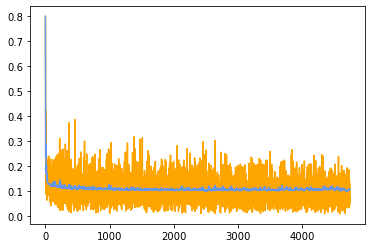

In [24]:
import matplotlib.pyplot as plt
plt.plot(range(max_len), losses1, c="orange")
plt.plot(range(max_len), val_losses1, c="cornflowerblue")
#plt.plot(range(max_len), losses2, c="cornflowerblue")
#plt.plot(range(max_len), losses3, c="pink")
#plt.plot(range(max_len), losses4, c="yellow")
plt.show()

In [25]:
model = module1
model.load_state_dict(torch.load('best_model.txt'))
model.eval()
roc_auc_score(valid[1].detach().numpy().reshape([-1,]), module1(valid[0]).cpu().detach().numpy().reshape([-1,]))

0.8621531002850971

In [26]:
prediction = module1(torch.Tensor(data.target_x.values).cuda())
result = pd.DataFrame(prediction.cpu().detach().numpy(),index=data.target_x.index, columns=["isFraud"])
result.to_csv("newsample_submission.csv")